## Airsoft Target Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
from scipy.signal import find_peaks


def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

: 

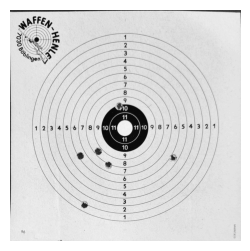

In [23]:
image = io.imread(f'resources/aligned/shot_3.jpg')
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(img, cmap="gray")

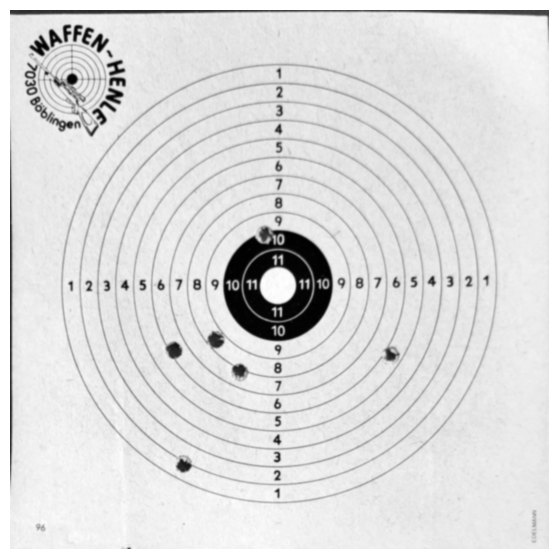

In [24]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), np.uint8)
#gray_image = cv2.erode(gray_image, kernel)
gray_image = cv2.GaussianBlur(gray_image, (15,15), 0)
# gray_image = cv2.bitwise_not(gray_image)
# gray_image = cv2.resize(gray_image, (0, 0), fx=0.35, fy=0.35)
show_image(gray_image, cmap='gray', size=(7,7))

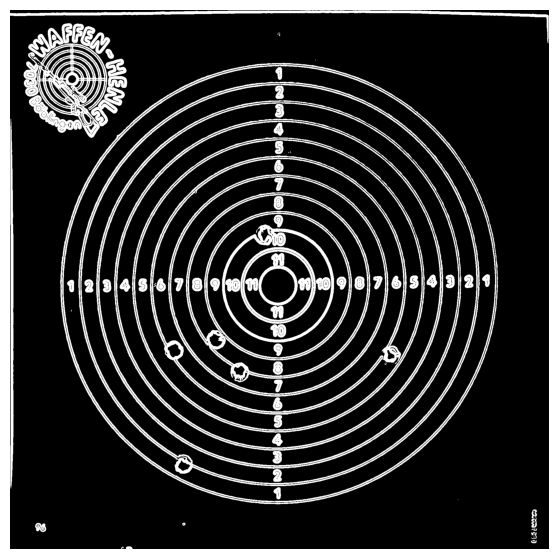

In [25]:
# canny = cv2.Canny(image=gray_image, threshold1=35, threshold2=200)

sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Normalize and threshold the result
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255
canny = sobel
# canny = io.imread('resources/aligned/test.png')
# canny = cv2.cvtColor(canny, cv2.COLOR_BGR2GRAY)
show_image(canny, cmap='gray', size=(7,7))

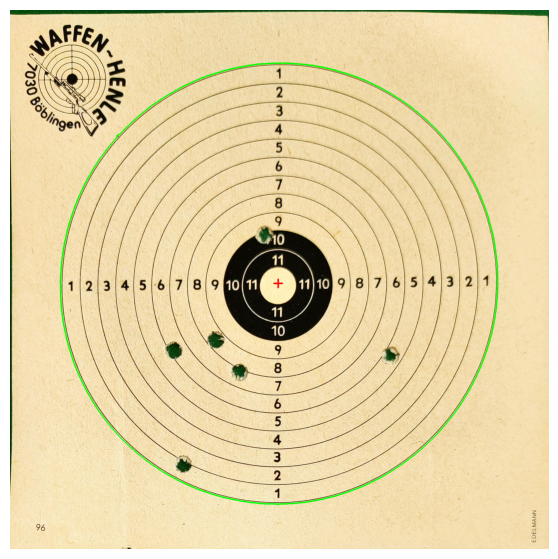

In [26]:
# find the biggest contour
contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    # cv2.drawContours(marked, [contour], -1, (0, 255, 255), 3)
    radius = cv2.minEnclosingCircle(contour)[1]
    area = cv2.contourArea(contour)
    total = area * radius
    if total > biggest_radius:
        biggest_radius = total
        biggest_cntr = contour

cv2.drawContours(marked, [biggest_cntr], -1, (0, 255, 0), 3)

# find center of countour

(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)

# convert center position to integers
centerX = int(centerX)
centerY = int(centerY)

cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
show_image(marked, size=(7,7))

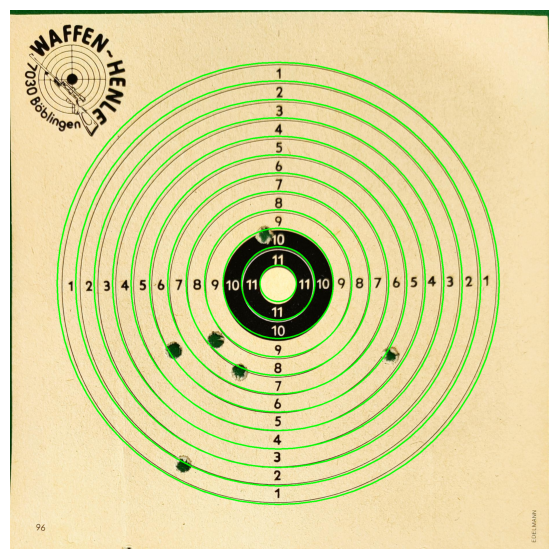

In [27]:
marked = image.copy()
for i in range(1, 13):
    cv2.circle(marked, (centerX, centerY), int(biggest_radius * i / 12), (0, 255, 0), 3)
show_image(marked, size=(7,7))

In [1]:
def houghCirclesAroundFix(image, fix):
    width, height = image.shape
    acc = np.zeros(width)
    x_f, y_f = fix
    for x in range(width):
        for y in range(height):
            if image[x, y] > 0:
                radius = np.floor(np.sqrt((x_f - x)**2 + (y_f - y)**2)).astype("int")
                acc[radius] = acc[radius] + 1
    acc = acc / (np.arange(width)+1)
    acc = acc * 100
    # acc[acc < 150] = 0
    peaks, _ = find_peaks(acc, prominence=5, distance=20)

    plt.plot(peaks,  acc[peaks], "xr")
    plt.plot(acc)
    plt.show()

    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return peaks

marked = image.copy()
test = cv2.Canny(image=gray_image, threshold1=35, threshold2=70)
show_image(test, cmap='gray', size=(7,7))
circles = houghCirclesAroundFix(test, (centerX, centerY))
for r in circles:
    output_1 = cv2.circle(marked, (centerX, centerY), r, (255, 0, 0), 1)
show_image(marked, size=(7,7))

NameError: name 'image' is not defined

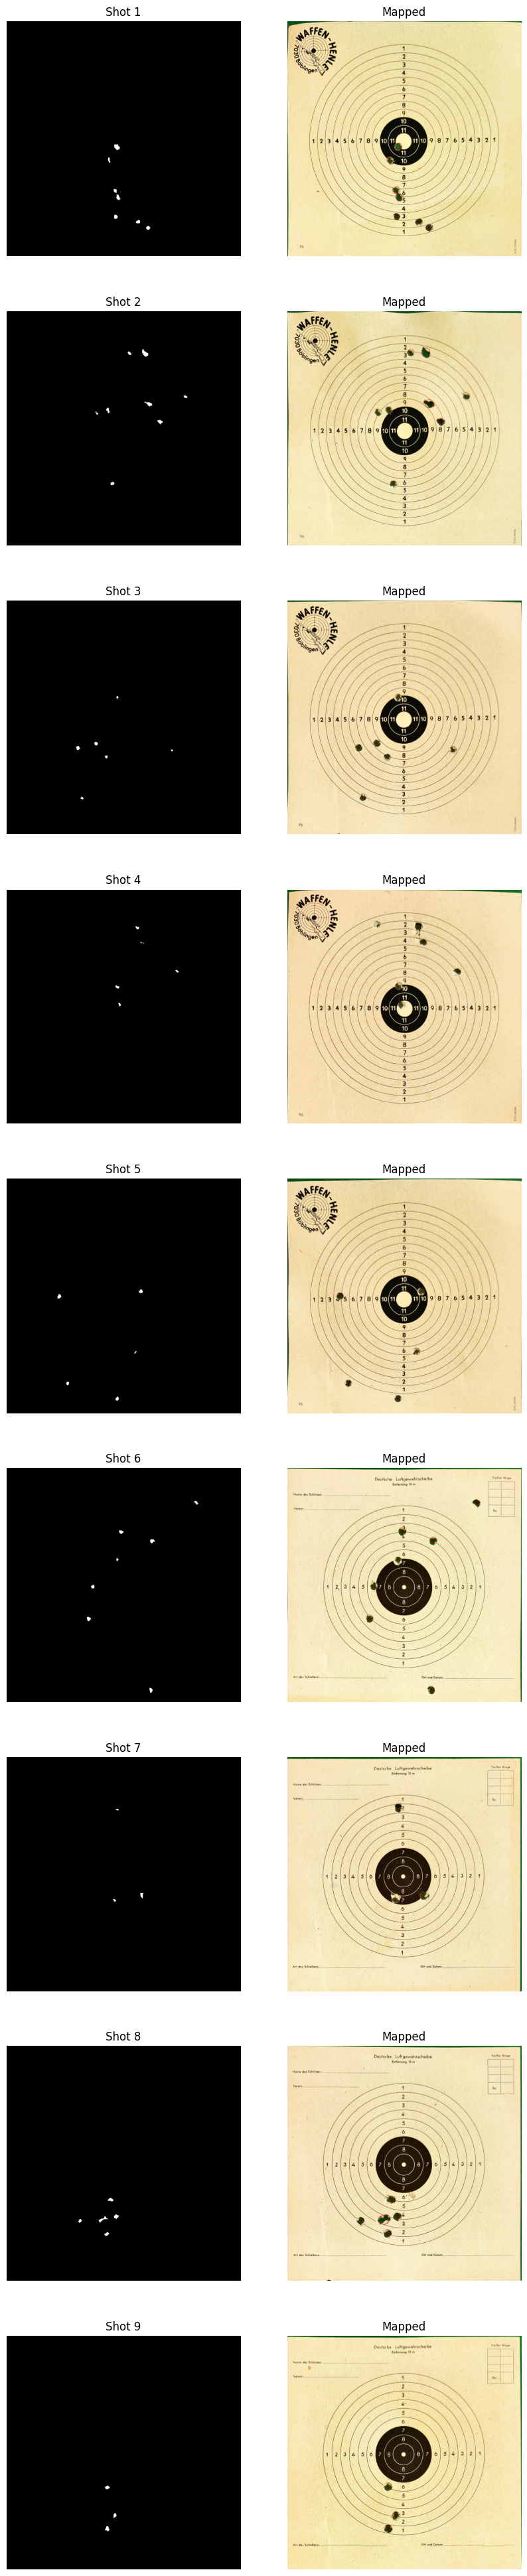

In [29]:

number_shot_images = 9

fig, axs = plt.subplots(number_shot_images, 2, figsize=(10, 50))
images =[]
for i in range(1, number_shot_images+1):
    img = io.imread(f'resources/aligned/shot_{i}.jpg')

    # convert the BGR image to HSV colour space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # set the lower and upper bounds for the green hue
    lower_green = np.array([20, 80, 20])
    upper_green = np.array([90, 255, 255])

    # create a mask for green colour using inRange function
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # perform bitwise and on the original image arrays using the mask
    res = cv2.bitwise_and(img, img, mask=mask)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    
    # res = cv2.dilate(res, kernel, iterations=1)
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, np.ones((3,3)), iterations=5)
    res = cv2.erode(res, np.ones((7,7)), iterations=2)
    res = cv2.erode(res, np.ones((3,3)), iterations=2)

    ret, res = cv2.threshold(res, 20, 255, cv2.THRESH_BINARY)
    res = res.astype(np.uint8)
    border_width = 50
    res[:border_width, :] = 0
    res[-border_width:, :] = 0
    res[:, :border_width] = 0
    res[:, -border_width:] = 0
    images.append(res)
    axs[i-1,0 ].imshow(res, cmap="gray")
    axs[i-1,0].set_title(f'Shot {i}')
    axs[i-1,0].axis('off')
    contours, hierarchy = cv2.findContours(
        res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image2 = img.copy()
    # draw min enclosing circle for each contour
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image2, center, radius, (255, 0, 0), 2)
    # display the images
    axs[i-1, 1].imshow(image2)
    axs[i-1, 1].set_title(f'Mapped')
    axs[i-1, 1].axis('off')
    

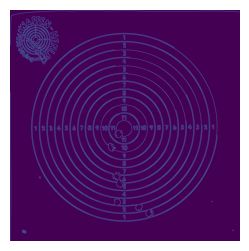

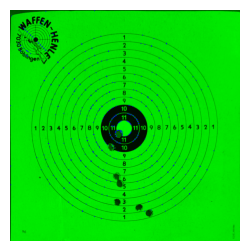

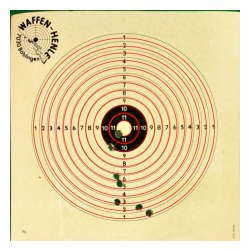

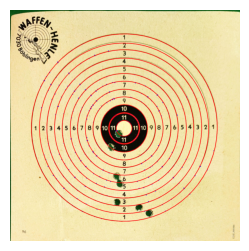

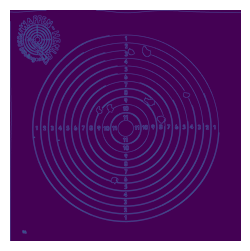

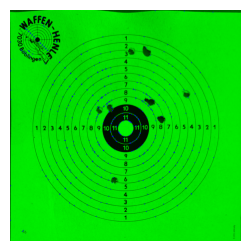

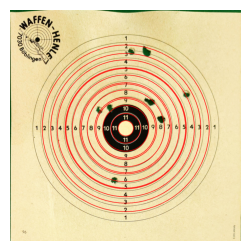

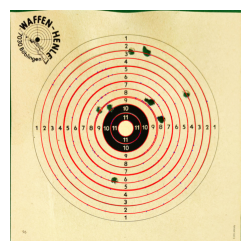

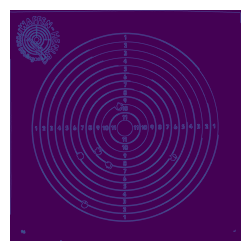

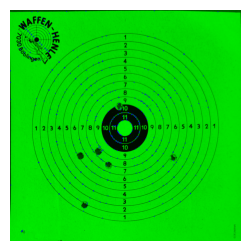

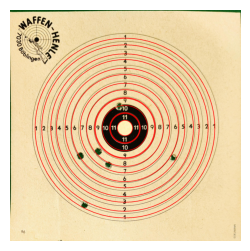

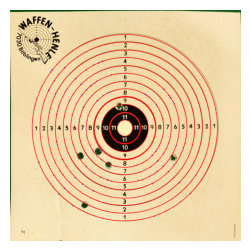

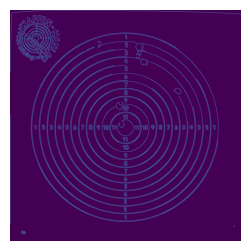

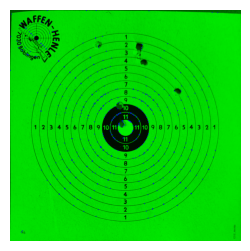

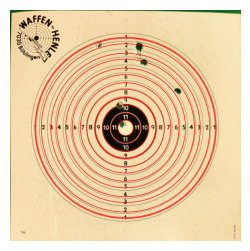

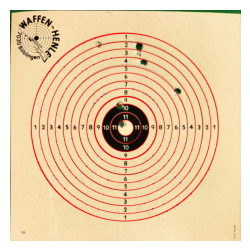

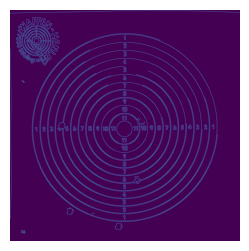

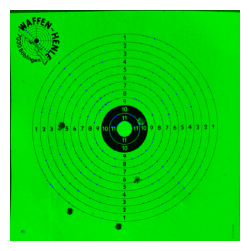

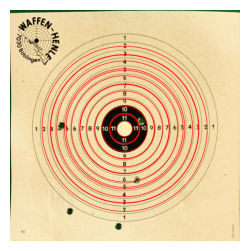

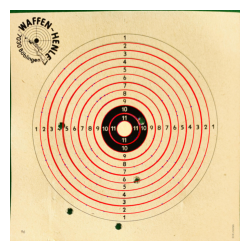

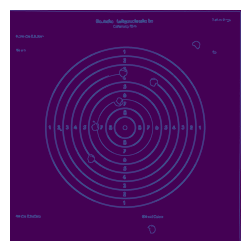

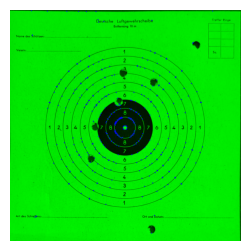

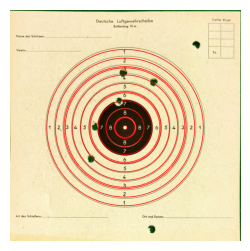

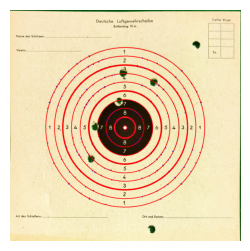

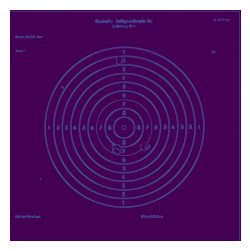

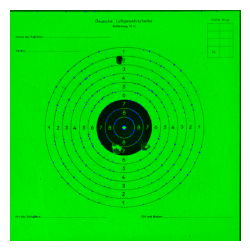

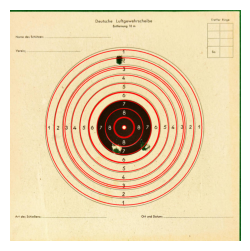

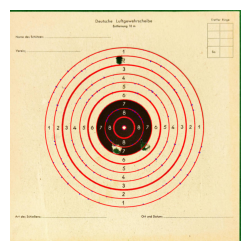

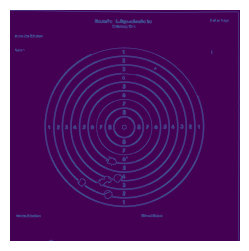

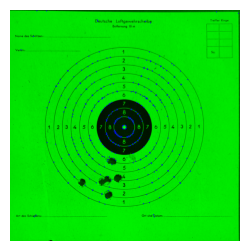

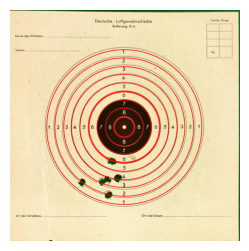

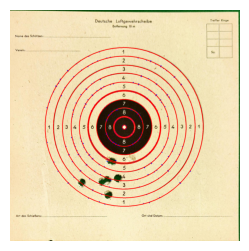

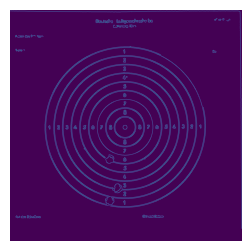

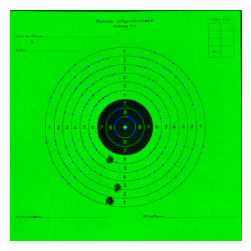

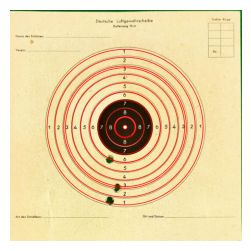

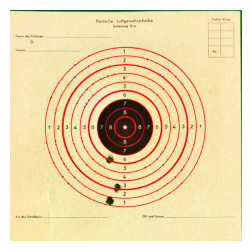

In [50]:

from collections import Counter
number_shot_images = 9
def houghCirclesAroundFix(image, fix):
    width, height = image.shape
    acc = np.zeros(width)
    x_f, y_f = fix
    for x in range(width):
        for y in range(height):
            if image[x, y] > 0:
                radius = np.floor(np.sqrt((x_f - x)**2 + (y_f - y)**2)).astype("int")
                acc[radius] = acc[radius] + 1
    acc = acc / (np.arange(width)+1)
    acc = acc * 100
    # acc[acc < 150] = 0
    peaks, _ = find_peaks(acc, prominence=5, distance=20)


    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return peaks


#fig, axs = plt.subplots(number_shot_images, 2, figsize=(10, 50))
avg = []
for i in range(1, number_shot_images+1):
    img = io.imread(f'resources/aligned/shot_{i}.jpg')
    shape_x,shape_y,useless=img.shape
    temp = img.copy()
    marked = img.copy()
    img[:,:,2]=0
    img[:,:,0]=0
    # convert the BGR image to HSV colour space
    res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, res = cv2.threshold(res, 20, 255, cv2.THRESH_BINARY)
    res = res.astype(np.uint8)
    border_width=300
    res[:border_width, :] = 255
    res[-border_width:, :] = 255
    res[:, :border_width] = 255
    res[:, -border_width:] = 255

    res = res + images[i-1]

    kernel_erode = np.array([
                [0,0,0,1,1,1,0,0,0],
                [0,0,1,1,1,1,1,0,0],
                [0,1,1,1,1,1,1,1,0],
                [1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1],
                [0,1,1,1,1,1,1,1,0],
                [0,0,1,1,1,1,1,0,0],
                [0,0,0,1,1,1,0,0,0],
                ],dtype=np.uint8)
    #
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel_erode, iterations=2)
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel_erode, iterations=13)

    contours, hierarchy = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x,y = res.shape
    biggest_cntr = None
    biggest_radius = 0
    for contour in contours:
        radius = cv2.minEnclosingCircle(contour)[1]
        if radius > biggest_radius and radius<1000:
            biggest_radius = total
            biggest_cntr = contour
    (x,y),radius = cv2.minEnclosingCircle(biggest_cntr)
    x_center =x
    y_center =y
    cv2.circle(temp, (int(x),int(y)), int(radius), (255,0,0), 3)
    cv2.drawMarker(temp, (int(x),int(y)), (0,0,255), markerType=cv2.MARKER_CROSS, markerSize=4, thickness=4)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (15,15), 0)
    test = cv2.Canny(image=gray_image, threshold1=35, threshold2=70)
    test2 = test.copy()
    show_image(test)
    data = np.zeros(gray_image.shape)
    thisdict = {}
    b_size = 18
    currentBucket = 0
    for y_inc in range(-5,5):
        for x_inc in range(-5,5):
            currentBucket = 0
            if(x_inc==0 or y_inc==0):
                continue
            x,y =int(x_center),int(y_center)
            while(0<x and x <shape_x-20 and 0 < y and y < shape_y-20 ) :
                bucket = np.floor(np.sqrt((x-x_center)**2 + (y-y_center)**2))
                if(np.abs(bucket-currentBucket)>b_size):
                    currentBucket = currentBucket+b_size
                bucket = currentBucket

                if not bucket in thisdict:
                    thisdict[bucket]=[]

                if(test[y,x] >0):
                    thisdict[bucket].append((x,y))
                    cv2.drawMarker(img, (x,y), (0,0,255), markerType=cv2.MARKER_CROSS, markerSize=4, thickness=4)
                x=x+x_inc
                y=y+y_inc

    marked2 = marked.copy()
    for elem in thisdict.values():
        temp_length=[]
        temp_length.append(len(elem))
        #
        if len(elem)>20:
            for point in elem:
                temp_length.append( np.sqrt((point[0]-x_center)**2 + (point[1]-y_center)**2))
                cv2.drawMarker(marked2, point, (0,0,255), markerType=cv2.MARKER_CROSS, markerSize=4, thickness=4)
            (x5,y5),rad = cv2.minEnclosingCircle(np.array(elem))
            ellipse = cv2.fitEllipse(np.array(elem))
            cv2.ellipse(marked2, ellipse, (255, 0, 0), 4)
            cv2.circle(marked, (int(x_center), int(y_center)), int(np.mean(temp_length)), (255, 0, 0), 4)

    show_image(img)
    show_image(marked)
    show_image(marked2)


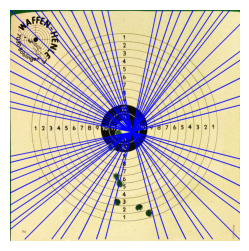

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
img = io.imread(f'resources/aligned/shot_1.jpg')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
shape_x, shape_y = gray_image.shape

for y_inc in range(-5,5):
    for x_inc in range(-5,5):
        if(x_inc==0 or y_inc==0):
            continue
        x,y =1000,1000
        while(0<x<shape_x-4 and 0 < y < shape_y-4 ) :
            cv2.drawMarker(img, (x,y), (0,0,255), markerType=cv2.MARKER_CROSS, markerSize=4, thickness=4)
            x=x+x_inc
            y=y+y_inc

show_image(img)
